![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)


## 1. Get the Data

You can find the data at this Google Drive URL (NPZ format)

https://drive.google.com/file/d/1-OplAg9THXuzKC_oYAiB4wdBmCTdiy4z/view?usp=sharing <br>
https://drive.google.com/file/d/1-Svi93L-C7qAq2oJmtajfCJDjGdJTIaE/view?usp=sharing <br>
https://drive.google.com/file/d/1-Dpozh1KCEvuCYgYuaf98-PzHhHTo3F_/view?usp=sharing <br>


If working at colab, mount Google Drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Libraries

To begin, let's load those libraries that we need

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model

## 3. Defining some constants

In [7]:
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# We define the path where you have the NPZ files
path = "drive/MyDrive/"

## 4. We prepare the training data

We will load them in the NPZ format that we discussed in the last class

In [8]:
dict_npz = np.load(path+'xy_train_img.npz')
x_train_img = dict_npz['x']
y_train_img = dict_npz['y']

dict_npz = np.load(path+'xy_test_img.npz')
x_test_img = dict_npz['x']
y_test_img = dict_npz['y']

dict_npz = np.load(path+'xy_val_img.npz')
x_val_img = dict_npz['x']
y_val_img = dict_npz['y']

x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.
x_val_scaled = x_val_img / 255.

In [9]:
print("Shape X train:", x_train_scaled.shape)
print("Shape Y train:", y_train_img.shape)

print("Shape X test:", x_test_scaled.shape)
print("Shape Y test:", y_test_img.shape)

print("Shape X val:", x_val_scaled.shape)
print("Shape Y val:", y_val_img.shape)



Shape X train: (5000, 150, 150, 3)
Shape Y train: (5000,)
Shape X test: (1000, 150, 150, 3)
Shape Y test: (1000,)
Shape X val: (1000, 150, 150, 3)
Shape Y val: (1000,)


## 5. Explore the data

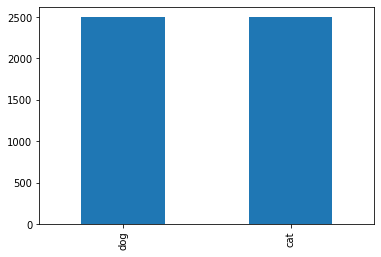

In [10]:
df_train = pd.DataFrame(y_train_img, columns=['category'])
df_train['category'].value_counts().plot.bar()

As we can see we have 2500 examples of each class ... a little to be a neural network for computer vision ... you will see ...

## 6. Lets see an image

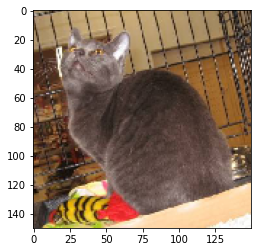

In [11]:
sample = random.choice(range(0,4999))
image = x_train_scaled[sample]
plt.imshow(image, cmap=plt.cm.binary)

## 7. Let's stack blocks to make the model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

### 7.1 Let's get our feature extractor VGG16

In [12]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

58900480/58889256 [==============================] - 1s 0us/step


In [13]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
output = vgg.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
vgg_model = Model(vgg.input, new_output_layer)

In [15]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [16]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type', 'Name of layer', 'Trainable?'])

,Layer type,Name of layer,Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7f8cac5f7f50>,input_1,True
1,<keras.layers.convolutional.Conv2D object at 0x7f8caafabd10>,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0x7f8cab0075d0>,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0x7f8caafa4350>,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0x7f8ca97147d0>,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0x7f8ca9719190>,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0x7f8ca9716ed0>,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0x7f8ca9716e90>,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0x7f8ca0668510>,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0x7f8ca0668550>,block3_conv3,True


In [17]:
vgg_model.trainable

True

In [18]:
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

In [19]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer type', 'Name of layer', 'Trainable?'])

,Layer type,Name of layer,Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7f8cac5f7f50>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f8caafabd10>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f8cab0075d0>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f8caafa4350>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f8ca97147d0>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f8ca9719190>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f8ca9716ed0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f8ca9716e90>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f8ca0668510>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f8ca0668550>,block3_conv3,False


### 7.2 Get VGG16 features of images

In [20]:
def getVGG16Features(model, input_imgs):
    return model.predict(input_imgs)

In [21]:
x_train_post_vgg16 = getVGG16Features(vgg_model, x_train_scaled)
x_val_post_vgg16 = getVGG16Features(vgg_model, x_val_scaled)
x_test_post_vgg16 = getVGG16Features(vgg_model, x_test_scaled)


### 7.3 Build classifier network

In [22]:
input_shape = vgg_model.output_shape[1]
print(input_shape)

8192


In [23]:
model = ks.Sequential()

model.add(ks.layers.Dense(512, activation='relu', input_shape=(input_shape,)))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(1, activation='sigmoid')) # 1 of output as the target is binary (0 or 1)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


## 8. Let's compile the model

In [24]:
from tensorflow.keras.optimizers import Adam

In [25]:
new_adam = Adam(learning_rate=0.0005)

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

## 9. Let's define a callback for early stopping

**Early Stopping**

We prevent overfitting by stopping when after 10 epochs and the validation error does not decrease (we are in a plateau)

In [26]:
callback_val_loss = EarlyStopping(monitor="val_loss", patience=5)
callback_val_accuracy = EarlyStopping(monitor="val_accuracy", patience=10)

## 10. Prepare the data


We will do a one-hot encoding that will be good for our classification

In [27]:
y_train_img

array(['cat', 'cat', 'cat', ..., 'dog', 'dog', 'dog'], dtype='<U3')

In [28]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [29]:
y_train_encoded

array([0, 0, 0, ..., 1, 1, 1])

## 11. Transformer from images to consumable data for the neural network

**Train data**

Here we will include our image generation part (with starting code)

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
    )

train_generator = train_datagen.flow(
    x_train_img,  # Aquí hay que usar datos NO re-escalados... de ahi que no usemos x_train_rescaled!
    y_train_encoded, 
    batch_size=50
)

**Validation (test does not need it)**

Note that here the only modification is a rescaling, no modifications

In [31]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val_img, 
    y_val_encoded, 
    batch_size=20
)


## 12. Let's see what the data generator looks like

To fill in to see what the new image generator gives us

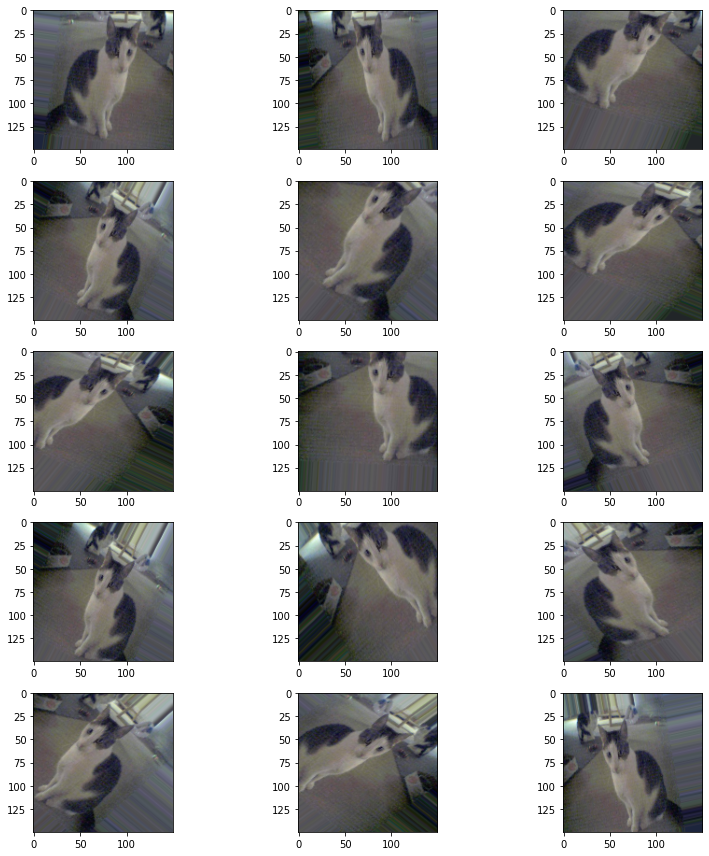

In [32]:
sample = random.choice(range(0,4999))

example_generator = train_datagen.flow(
    x_train_img[sample:sample+1],
    y_train_encoded[sample:sample+1],
    batch_size=1
)

plt.figure(figsize=(12, 12))
for i in range(0,15):
    plt.subplot(5, 3, i+1)
    for X,y in example_generator:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## 13. Model training

In [33]:
epochs = 200

history = model.fit(x_train_post_vgg16, y_train_encoded, epochs=epochs, 
                    validation_data=(x_val_post_vgg16, y_val_encoded), batch_size=128, 
                    callbacks=[callback_val_loss, callback_val_accuracy])

Epoch 1/200
40/40 [==============================] - 2s 19ms/step - loss: 0.5543 - accuracy: 0.7592 - val_loss: 0.2680 - val_accuracy: 0.8760
Epoch 2/200
40/40 [==============================] - 1s 13ms/step - loss: 0.2519 - accuracy: 0.8942 - val_loss: 0.2228 - val_accuracy: 0.9010
Epoch 3/200
40/40 [==============================] - 1s 13ms/step - loss: 0.2048 - accuracy: 0.9182 - val_loss: 0.2900 - val_accuracy: 0.8740
Epoch 4/200
40/40 [==============================] - 1s 13ms/step - loss: 0.1669 - accuracy: 0.9352 - val_loss: 0.2752 - val_accuracy: 0.8950
Epoch 5/200
40/40 [==============================] - 1s 13ms/step - loss: 0.1343 - accuracy: 0.9470 - val_loss: 0.2537 - val_accuracy: 0.8990
Epoch 6/200
40/40 [==============================] - 1s 13ms/step - loss: 0.1169 - accuracy: 0.9548 - val_loss: 0.3366 - val_accuracy: 0.8850
Epoch 7/200
40/40 [==============================] - 1s 13ms/step - loss: 0.1060 - accuracy: 0.9574 - val_loss: 0.2582 - val_accuracy: 0.8980


## 14. Save the model

In [34]:
model.save(path+"basic_model.h5")

## 15. Let's see the results

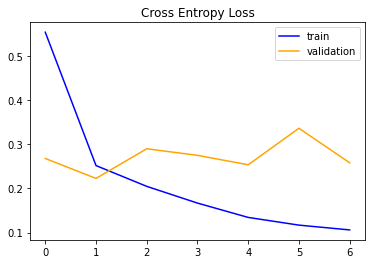

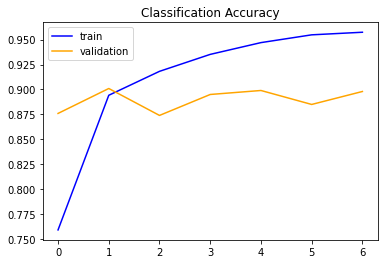

In [35]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [37]:
_, acc = model.evaluate(x_test_post_vgg16, y_test_encoded, verbose=0)
print('Test accuracy of the model without data augmentation -> %.3f' % (acc * 100.0))

Test accuracy of the model without data augmentation -> 90.400


## 16. Lets see some predictions

In [38]:
predictions = model.predict(x_test_post_vgg16) 


In [39]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    if true_label == 1:
        true_label = 'dog'
    else:
        true_label = 'cat'

    if np.max(predictions_array) > 0.50:
        predicted_label = 'dog'
    else:
        predicted_label = 'cat'

    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(1))
    plt.yticks([])

    if true_label == 1:
        true_label = 'dog'
    else:
        true_label = 'cat'

    if np.max(predictions_array) > 0.50:
        predicted_label = 'dog'
    else:
        predicted_label = 'cat'

    if predicted_label == true_label:
        color_plt = 'blue'
    else:
        color_plt = 'red'

    thisplot = plt.bar(range(1), np.max(predictions_array), color=color_plt)
    plt.ylim([0, 1])


We draw the first samples, with the predictions and their real values (a total of 20 images, so as not to abuse your laptops)

We color the correct predictions in blue and the failures in red

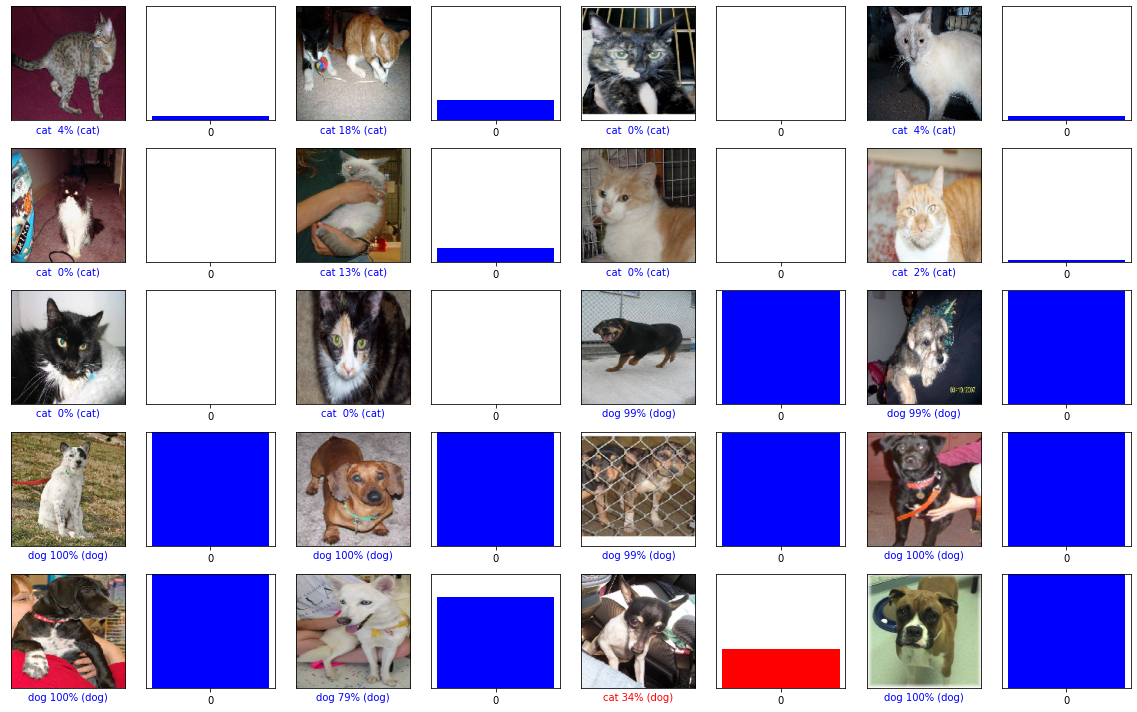

In [40]:
num_rows = 5
num_cols = 4
start = 490
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i+start, predictions[i+start], y_test_encoded, x_test_scaled)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i+start, predictions[i+start], y_test_encoded)
plt.tight_layout()
plt.show()